```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Time Series Decomposition

## Contents

- [Time series decomposition](#deco)
- [Load hourly data](#data_h)
- [Load daily data](#data_d)
- Time Series Decomposition
    - [The classical decomposition method](#cdm)
    - [Seasonal-Trend decomposition using LOESS (STL)](#stl)
    - [Decomposition process for modelling](#method)
    
    
    
- Moving Average Forecasts
    - [Simple Moving Average](#sma)
    - [Exponential Moving Average](#ema)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
from model import (
    get_pm25_data_for_modelling,
    #split_df_for_ts_modelling_percentage,
    #split_df_for_ts_modelling_date_range
)

#from measure import (
    #get_rmse
#)

from plot import (
    plot_stl,
    plot_decompose,
    plot_before_after
    #plot_observed_vs_predicted,
    #plot_train_test_predicted
)

---
<a id='deco'></a>

## Time Series Decomposition

`Time Series Decomposition` involves thinking of a series as a combination of level, trend, seasonality, and noise components. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components:
- **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.
- **Non-Systematic:** Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:
- **Level:** The average value in the series.
- **Trend:** The increasing or decreasing value in the series.
- **Seasonality:** The repeating short-term cycle in the series.
- **Noise:** The random variation in the series.

A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional.

There are two types of time series composition, linear and nonlinear:

- **An additive model** is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
- **A multiplicative model** is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A nonlinear seasonality has an increasing or decreasing frequency and/or amplitude over time.


XXXXXXXX
<img src="images/ts_002_simple_avderage.png" style="width: 200px;"/>

---
<a id='data_h'></a>

## Load hourly data

In [33]:
dfh = get_pm25_data_for_modelling('ts', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 01-Jun-20 22:44:07 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_hourly.hdf
common.py | 43 | get_pm25_data_for_modelling | 01-Jun-20 22:44:07 | INFO: Dataframe size: (96388, 1)


,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


In [34]:
#dfh.tail(24)

In [35]:
train_range_from_h = '2008-01-01 02:00:00'
train_range_to_h = '2018-12-30 23:00:00'
test_range_from_h = '2018-12-31 01:00:00'
test_range_to_h = None

---
<a id='data_d'></a>

## Load daily data

In [36]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 01-Jun-20 22:44:09 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 01-Jun-20 22:44:09 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [37]:
#dfd.tail(7)

In [38]:
train_range_from_d = '2008-01-01'
train_range_to_d = '2018-12-25'
test_range_from_d = '2018-12-26'
test_range_to_d = None

---
<a id='cdm'></a>

## The classical decomposition method 

### Hourly Frequency

In [64]:
df = dfh.copy()

In [65]:
# Work with different scope of PM2.5 observed (time series) data
series = df['pm25'] # hourly
#series = df['pm25'].resample(rule='D').mean() # daily
#series = df['pm25'].resample(rule='W').mean() # weekly
#series = df['pm25'].resample(rule='M').mean() # monthly
series.head()

Datetime
2008-01-01 01:00:00    92.0
2008-01-01 02:00:00    81.0
2008-01-01 03:00:00    73.0
2008-01-01 04:00:00    60.5
2008-01-01 05:00:00    61.0
Name: pm25, dtype: float64

In [66]:
series.name

'pm25'

In [67]:
series.index.freq

In [68]:
# Different rolling window would be appropriate for different resamplings
rolling_window = 4 # for D
#rolling_window = 6 # for W
#rolling_window = 3 # for M

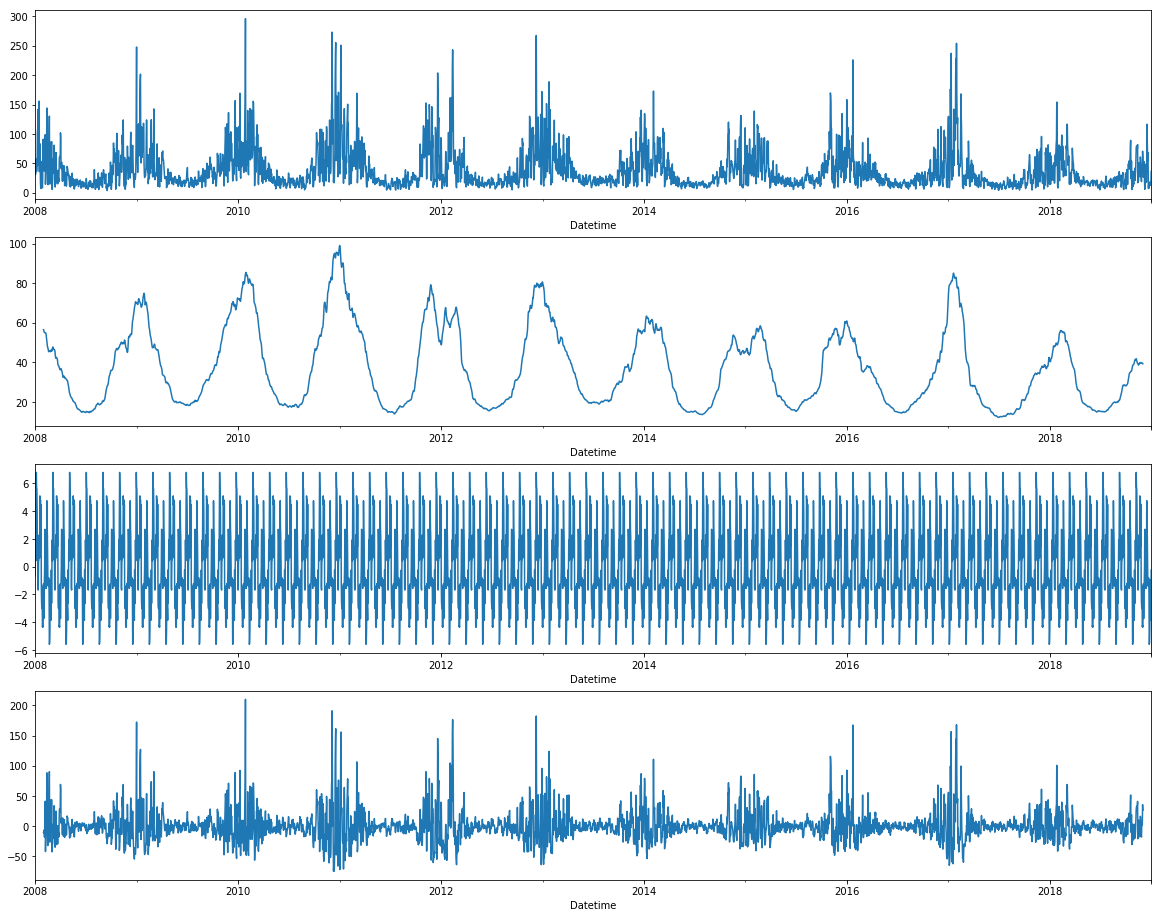

In [91]:
plot_decompose(data=series)

### Daily Frequency

In [70]:
df = dfd.copy()

In [71]:
# Work with different scope of PM2.5 observed (time series) data
#series = df['pm25'] # hourly
series = df['pm25'].resample(rule='D').mean() # daily
#series = df['pm25'].resample(rule='W').mean() # weekly
#series = df['pm25'].resample(rule='M').mean() # monthly
series.head()

Datetime
2008-01-01    53.586957
2008-01-02    30.958333
2008-01-03    46.104167
2008-01-04    42.979167
2008-01-05    57.312500
Freq: D, Name: pm25, dtype: float64

In [72]:
series.index.freq

<Day>

In [73]:
# Different rolling window would be appropriate for different resamplings
rolling_window = 4 # for D
#rolling_window = 6 # for W
#rolling_window = 3 # for M

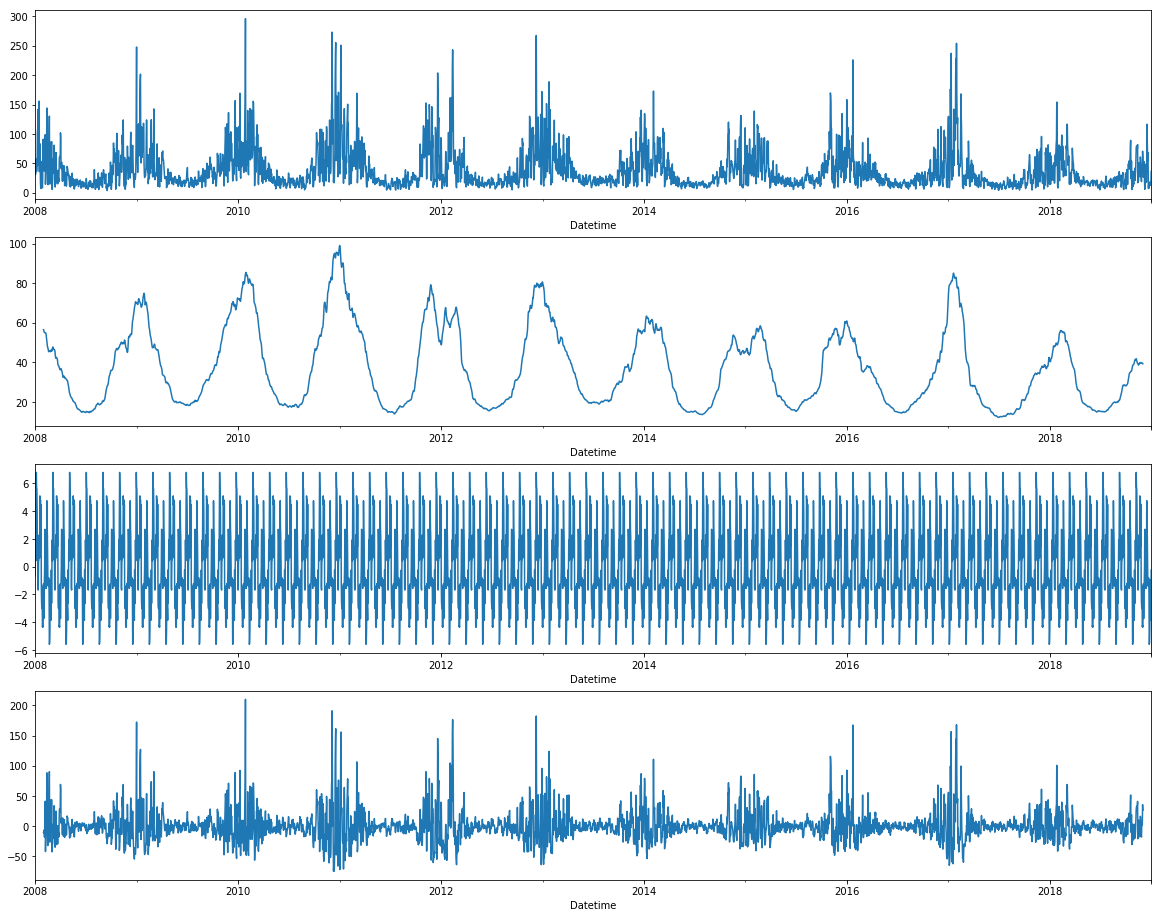

In [90]:
plot_decompose(data=series)

---
<a id='stl'></a>

## Seasonal-Trend decomposition using LOESS (STL)
STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. The key inputs into STL are:
- **seasonal** - The length of the seasonal smoother. Must be odd.
- **trend** - The length of the trend smoother, usually around 150% of seasonal. Must be odd and larger than seasonal.
- **low_pass** - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

### Hourly Frequency

In [50]:
df = dfh.copy()

In [51]:
# Work with different scope of PM2.5 observed (time series) data
series = df['pm25'] # hourly
#series = df['pm25'].resample(rule='D').mean() # daily
#series = df['pm25'].resample(rule='W').mean() # weekly
#series = df['pm25'].resample(rule='M').mean() # monthly
series.head()

Datetime
2008-01-01 01:00:00    92.0
2008-01-01 02:00:00    81.0
2008-01-01 03:00:00    73.0
2008-01-01 04:00:00    60.5
2008-01-01 05:00:00    61.0
Name: pm25, dtype: float64

In [52]:
# Different rolling window would be appropriate for different resamplings
rolling_window = 4 # for D
#rolling_window = 6 # for W
#rolling_window = 3 # for M

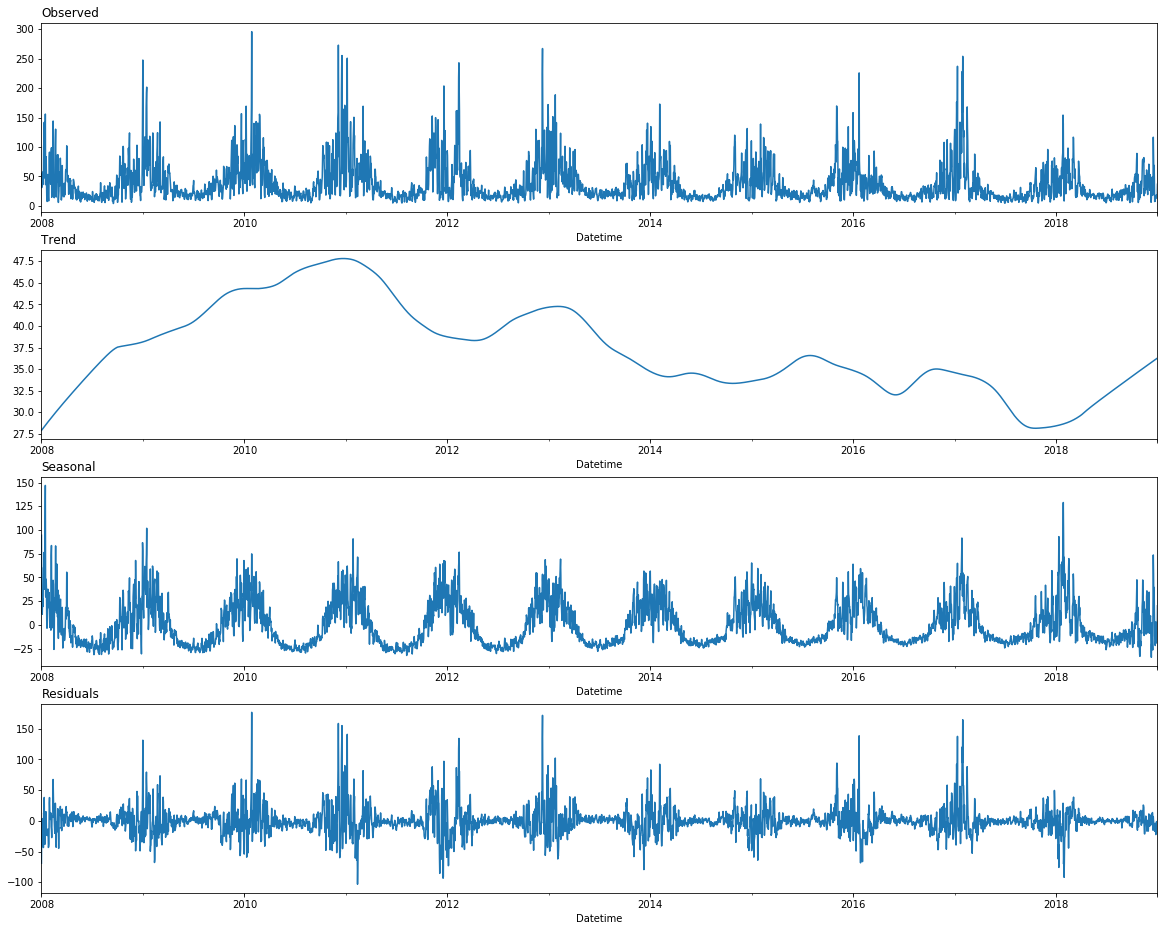

In [89]:
plot_stl(data=series, period=365, low_pass=367)

### Daily Frequency

In [54]:
df = dfd.copy()

In [55]:
# Work with different scope of PM2.5 observed (time series) data
#series = df['pm25'] # hourly
series = df['pm25'].resample(rule='D').mean() # daily
#series = df['pm25'].resample(rule='W').mean() # weekly
#series = df['pm25'].resample(rule='M').mean() # monthly
series.head()

Datetime
2008-01-01    53.586957
2008-01-02    30.958333
2008-01-03    46.104167
2008-01-04    42.979167
2008-01-05    57.312500
Freq: D, Name: pm25, dtype: float64

In [56]:
# Different rolling window would be appropriate for different resamplings
rolling_window = 4 # for D
#rolling_window = 6 # for W
#rolling_window = 3 # for M

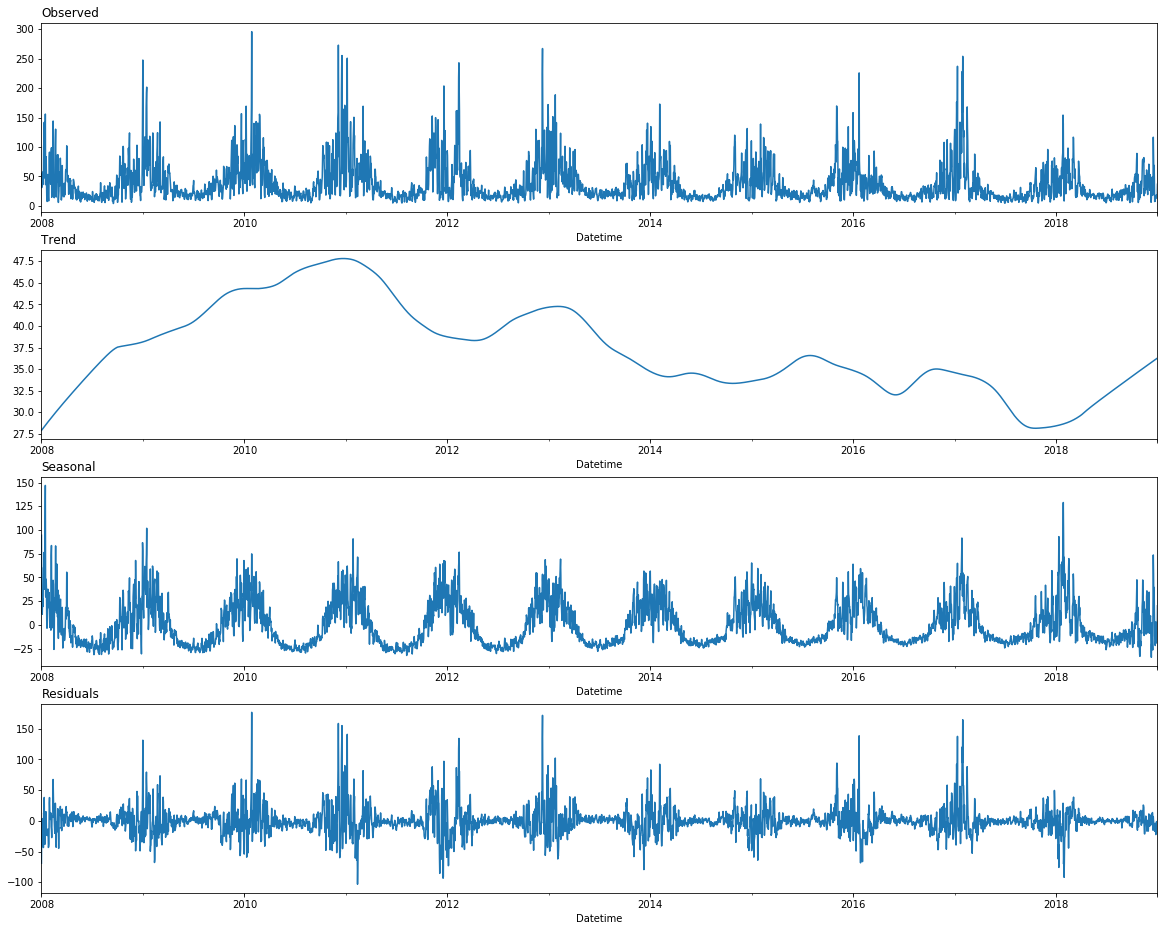

In [87]:
plot_stl(data=series, period=365)

---
<a id='method'></a>

## Decomposition process for modelling
Here, choose the decomposition method to move forward and the dataset (hourly, daily).

For the `clasical modelling`, we will focus on `residuals`, as they should be `stationary` (still to be confirmed below).

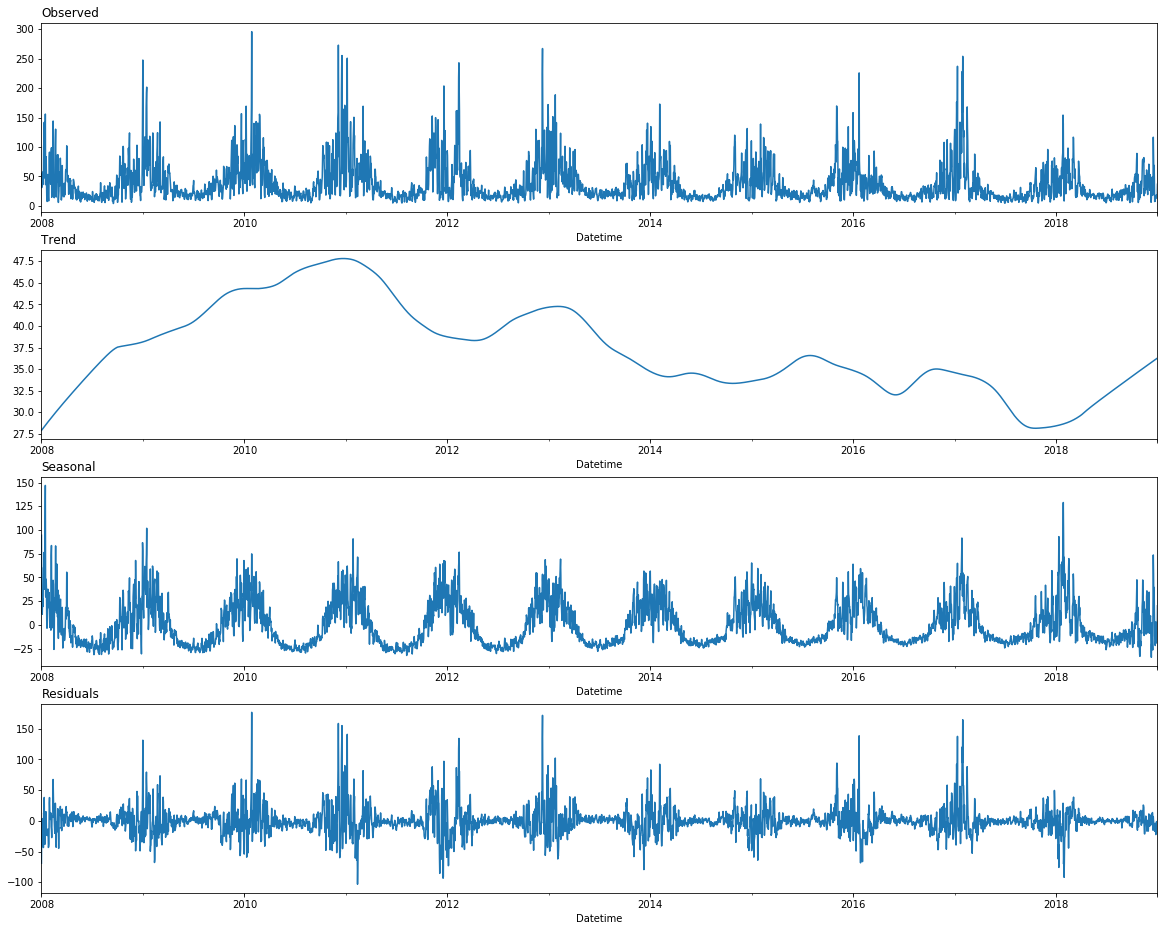

In [80]:
# STL for Daily Data
result = plot_stl(data=dfd['pm25'], period=365, low_pass=367)

### Observed data

In [83]:
result.observed[:5]

Datetime
2008-01-01    53.586957
2008-01-02    30.958333
2008-01-03    46.104167
2008-01-04    42.979167
2008-01-05    57.312500
Freq: D, Name: pm25, dtype: float64

### Use and remove trend
Our time series may contain a trend. A `trend` is a continued increase or decrease in the series over time.

Identifying and understanding `trend` information can aid in improving model performance; below are a few reasons:

- **Faster Modeling:** Perhaps the knowledge of a trend or lack of a trend can suggest methods and make model selection and evaluation more efficient.
- **Simpler Problem:** Perhaps we can correct or remove the trend to simplify modeling and improve model performance.
- **More Data:** Perhaps we can use trend information, directly or as a summary, to provide additional information to the model and improve model performance.

A time series with a trend is called `trend non-stationary`. An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called `detrending` the time series. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be `trend stationary`.

Specifically, a `trend` can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. Alternately, a trend can be added, either directly or as a summary, as a new input variable to the supervised learning problem to predict the output variable.

Perhaps the simplest method to detrend a time series is by `differencing`. Specifically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

In [84]:
result.trend[:5]

Datetime
2008-01-01    27.904629
2008-01-02    27.947183
2008-01-03    27.989668
2008-01-04    28.032084
2008-01-05    28.074429
Freq: D, Name: trend, dtype: float64

In [107]:
# Detrend a time series using differencing
series = result.observed
X = series.values
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
diff = pd.Series(diff, index=result.observed.index[1:])

Because no difference value can be created for the first observation (there is nothing for it to be subtracted from), the new dataset contains one less record. This approach works well for data with a linear trend. If the trend is quadratic (the change in the trend also increases or decreases), then a difference of the already-differenced dataset can be taken, a `second level of differencing`.

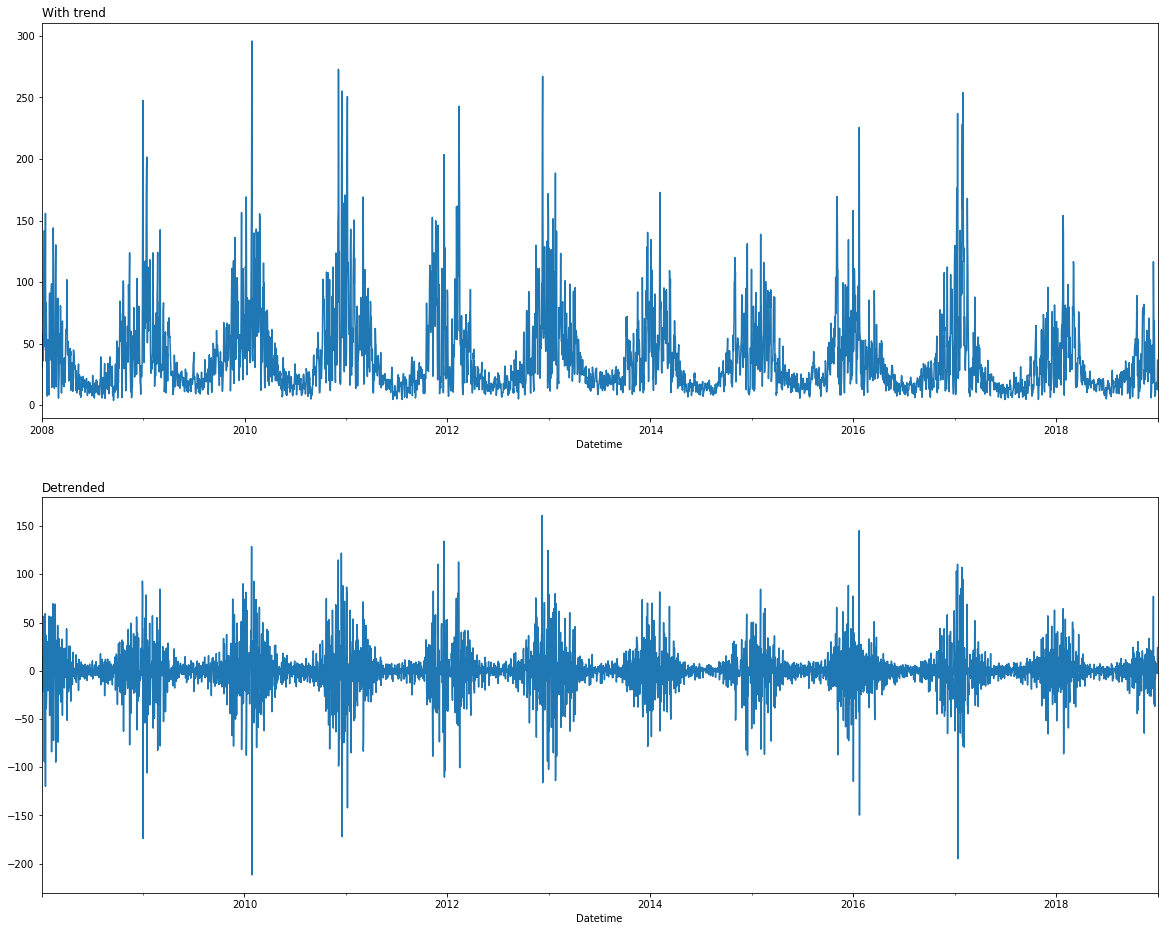

In [108]:
plot_before_after(result.observed, diff, "With trend", "Detrended")

In [135]:
# Use a linear model to detrend a time series
from sklearn.linear_model import LinearRegression
import numpy as np

series = result.observed

# Create integer-indexed observations
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
print(X[:5])

y = series.values
print(y[:5])

# Fit linear model
model = LinearRegression()
model.fit(X, y)

# Calculate trend
trend1 = model.predict(X)
print(trend1[:5])

# Detrend
detrended = [y[i] - trend1[i] for i in range(0, len(series))]
print(detrended[:5])

[[0]
 [1]
 [2]
 [3]
 [4]]
[53.58695652 30.95833333 46.10416667 42.97916667 57.3125    ]
[43.97819481 43.97481936 43.97144391 43.96806846 43.96469301]
[9.608761707709753, -13.016486028819504, 2.132722756390365, -0.9889017917330918, 13.347806993476787]


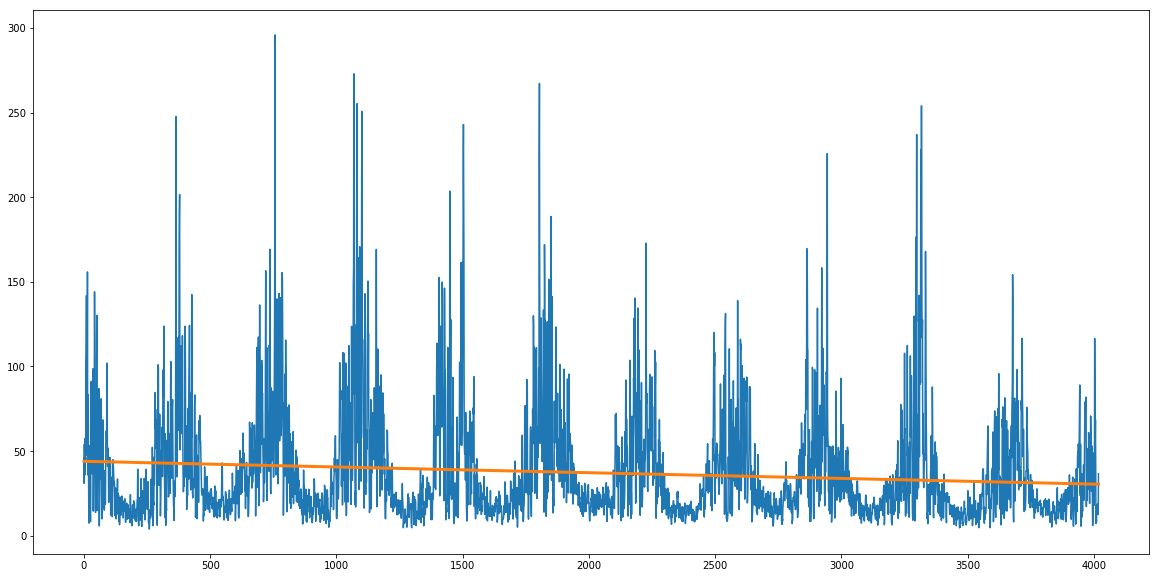

In [140]:
# Plot trend
plt.figure(figsize=(20, 10))
plt.plot(y)
plt.plot(trend1, linewidth=3)
plt.show();

In [137]:
# Check what is the trend line now
model.fit(X, detrended)

# Calculate trend (should be 0 now, flat horizontal line)
trend2 = model.predict(X)
print(trend2[:5])

[-4.50655520e-16 -4.52346124e-16 -4.54036728e-16 -4.55727332e-16
 -4.57417936e-16]


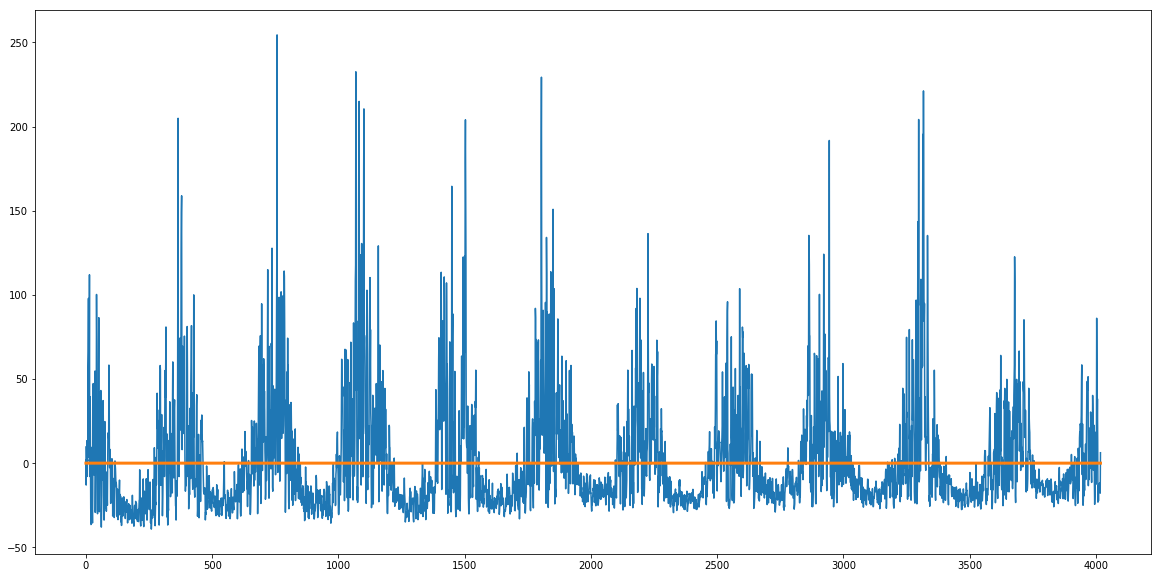

In [139]:
# Plot detrended
plt.figure(figsize=(20, 10))
plt.plot(detrended)
plt.plot(trend2, linewidth=3)
plt.show();

[43.97819481 43.97481936 43.97144391 43.96806846 43.96469301]


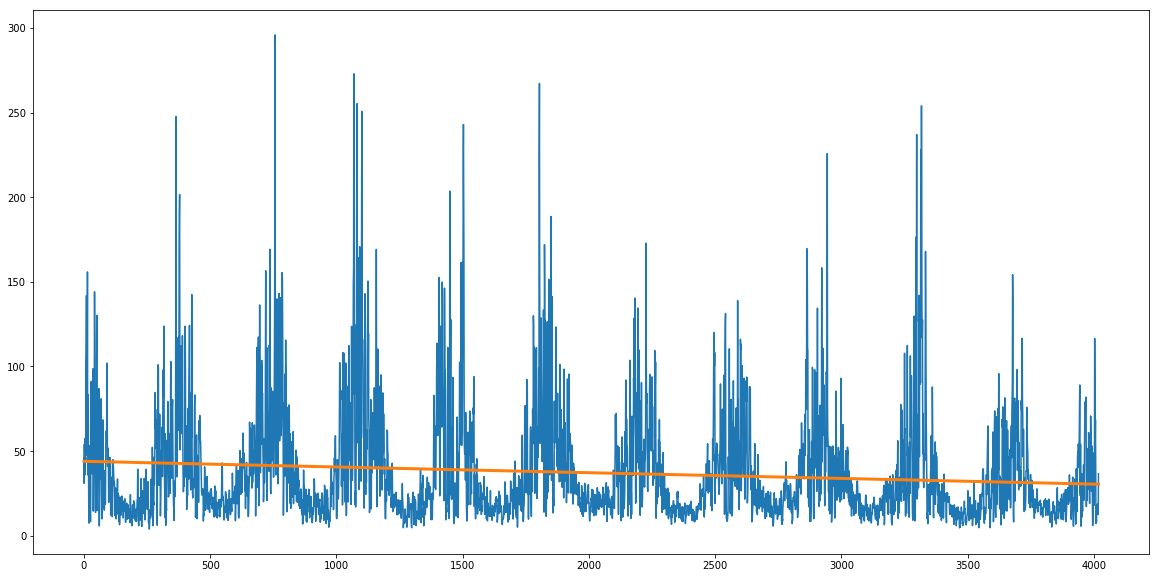

In [143]:
# Check what is the trend line now
model.fit(X, detrended+trend1)

# Calculate trend (should be back as at the beginning)
trend3 = model.predict(X)
print(trend3[:5])

# Plot detrended
plt.figure(figsize=(20, 10))
plt.plot(y)
plt.plot(trend3, linewidth=3)
plt.show();

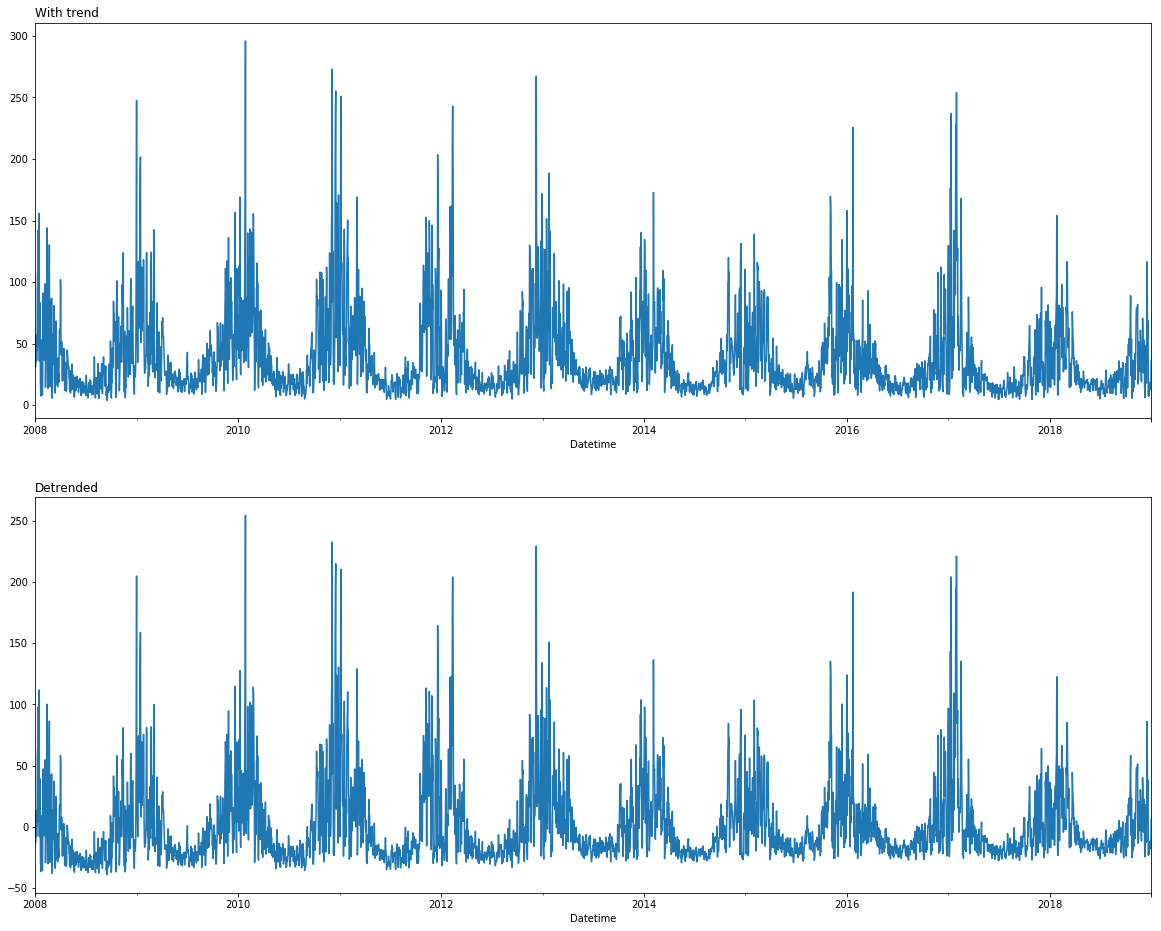

In [124]:
y = pd.Series(y, index=result.observed.index)
detrended = pd.Series(detrended, index=result.observed.index)
plot_before_after(y, detrended, "With trend", "Detrended")

### Use and remove seasonality

In [85]:
result.seasonal[:5]

Datetime
2008-01-01    94.496364
2008-01-02    14.806637
2008-01-03    16.350060
2008-01-04    11.232492
2008-01-05    27.397082
Freq: D, Name: season, dtype: float64

In [86]:
result.resid[:5]

Datetime
2008-01-01   -68.814036
2008-01-02   -11.795487
2008-01-03     1.764438
2008-01-04     3.714591
2008-01-05     1.840989
Freq: D, Name: resid, dtype: float64

In [ ]:
rmse = get_rmse(observed=df_test['pm25'], predicted=predicted['pred'])
print(f'{model_name} RMSE {rmse}')

---
<a id='sma'></a>

## Simple Moving Average (SMA)

In [ ]:
rmse = get_rmse(observed=df_test['pm25'], predicted=predicted)
print(f'{model_name} RMSE {rmse}')

---
<a id='ema'></a>

## Exponential Moving Average

In [ ]:
rmse = get_rmse(observed=df_test['pm25'], predicted=predicted)
print(f'{model_name} RMSE {rmse}')